# Импортируемые файлы

In [2]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import zipfile
import shutil
import transform_info as ti #Часть пункта 4
import help_defenition as hd #Вспомогательные функции

In [3]:
lr = 0.001
batch_size = 100
epochs = 3

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)

if device == 'cuda':
    torch.cuda.manual_seed_all(1234)

# Пункт 1 - 2

In [5]:
if os.path.isdir('data'):
    shutil.rmtree('data')
    os.makedirs('data', exist_ok=True)
    os.makedirs('data/train', exist_ok=True)
    os.makedirs('data/test', exist_ok=True)
    os.makedirs('data/validation', exist_ok=True)

    base_dir = 'dataset'
    with zipfile.ZipFile(os.path.join(base_dir, 'dataset_another.zip')) as train_zip:
        train_zip.extractall('data')

    list_of_something = os.listdir('data/dataset_another')
    for el in list_of_something:
        way = 'data/dataset_another/' + str(el)
        shutil.move(way, 'data/train')
    shutil.rmtree('data/dataset_another')

    list_train = os.listdir('data/train')
    list_test = list_train[:100] + list_train[-100:]
    hd.del_n_elem(list_train, 150)
    list_validation = []

    for elem in list_test:
        shutil.move("data/train/" + str(elem), "data/test")

    for i in range(len(list_train)):
        list_train[i] = "train/" + list_train[i]

    for i in range(len(list_test)):
        list_test[i] = "test/" + list_test[i]

    for i in range(len(list_validation)):
        list_validation[i] = "validation/" + list_validation[i]

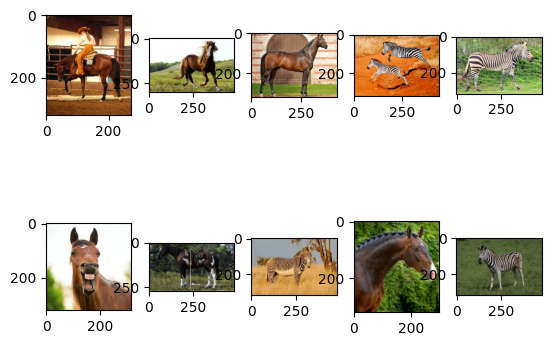

In [6]:
list_train, list_validation = train_test_split(
    list_train, test_size=1/9)

list_rand_index = []
hd.generate_mas(list_rand_index, 1, len(list_train) / 2, 5)
hd.generate_mas(list_rand_index, len(
    list_train) / 2 + 1, len(list_train), 5)
figure = plt.figure()
num_of_img = 1
for index in list_rand_index:
    figure.add_subplot(2, 5, num_of_img)
    way_to_file = "data/" + str(list_train[index])
    image = Image.open(way_to_file)
    plt.imshow(image)
    num_of_img += 1
plt.show()

## Все необходимые классы

In [7]:
class My_Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list: list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.file_list_len = len(self.file_list)

    def __len__(self) -> int:
        return self.file_list_len

    def __getitem__(self, index: int):
        way_to_file = "data/" + str(self.file_list[index])
        img = Image.open(way_to_file)
        img_transformed = self.transform(img)

        label = way_to_file.split('/')[-1].split('.')[0][:-5]
        if label == 'zebra':
            label = 0
        else:
            label = 1
        return img_transformed, label

class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,1)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.Flatten()(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return torch.nn.Sigmoid()(out)

# Пункт 3 - 4
Создание объектов классов; Пайплайн предобработки данных

In [8]:
myds_train = My_Dataset(list_train, ti.train_transforms)
myds_test = My_Dataset(list_test, ti.test_transforms)
myds_valid = My_Dataset(list_validation, ti.validation_transforms)

loader_train = torch.utils.data.DataLoader(
    dataset=myds_train, batch_size=batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(
    dataset=myds_test, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(
    dataset=myds_valid, batch_size=batch_size, shuffle=True)


In [9]:
model = Cnn().to(device)
model.train()

optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Пункт 5
Цикл обучения

In [10]:
accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

def train_loop(train_loader, val_loader):
    epochs = 10
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())
        
        model.eval()
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label.unsqueeze(dim=1).to(torch.float))
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        val_accuracy_values.append(epoch_val_accuracy.item())
        val_loss_values.append(epoch_val_loss.item())
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        print('\n')

# Пункт 6 - 8
Вывод графиков для каждого эксперимента; Оценка работы модели

In [11]:
train_loop(loader_train, loader_valid)

Epoch : 1, train accuracy : 0.49687498807907104, train loss : 0.0
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.0


Epoch : 2, train accuracy : 0.49687495827674866, train loss : 0.0
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.0


Epoch : 3, train accuracy : 0.49687498807907104, train loss : 0.0
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.0


Epoch : 4, train accuracy : 0.49687495827674866, train loss : 0.0
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.0


Epoch : 5, train accuracy : 0.49687498807907104, train loss : 0.0
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.0


Epoch : 6, train accuracy : 0.49687492847442627, train loss : 0.0
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.0


Epoch : 7, train accuracy : 0.49687498807907104, train loss : 0.0
Epoch : 7, val_accuracy : 0.5249999761581421, val_loss : 0.0


Epoch : 8, train accuracy : 0.49687498807907104, train loss : 0.0
Epoch : 8, val_accuracy : 0.524

In [12]:
def show_results(acc, loss):
    plt.figure(figsize=(15, 5))
    plt.plot(range(10), acc, color="green")
    plt.legend(["Accuracy"])
    plt.show()
    
    plt.figure(figsize=(15, 5))
    plt.plot(range(10), loss, color="blue")
    plt.legend(["Loss"])
    plt.show() 

    print(acc, '\n',loss)

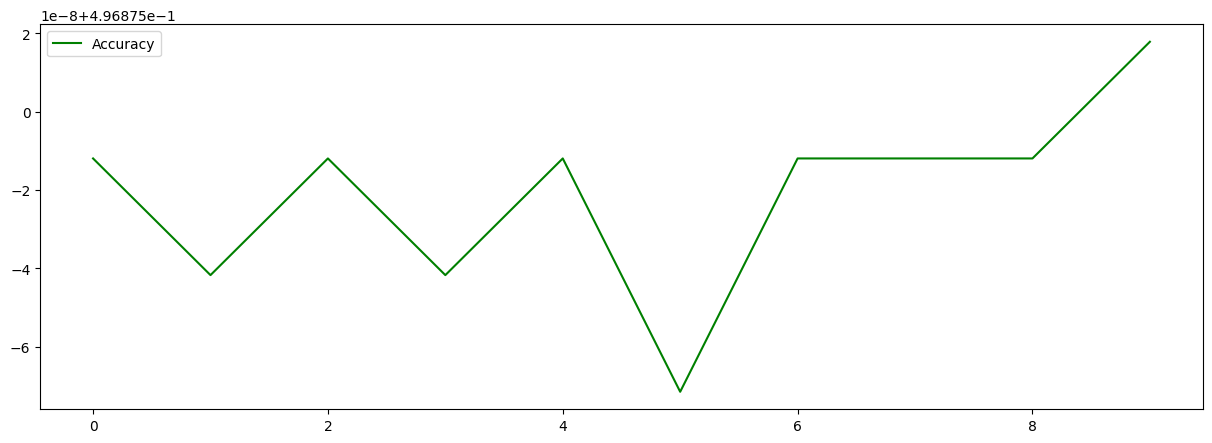

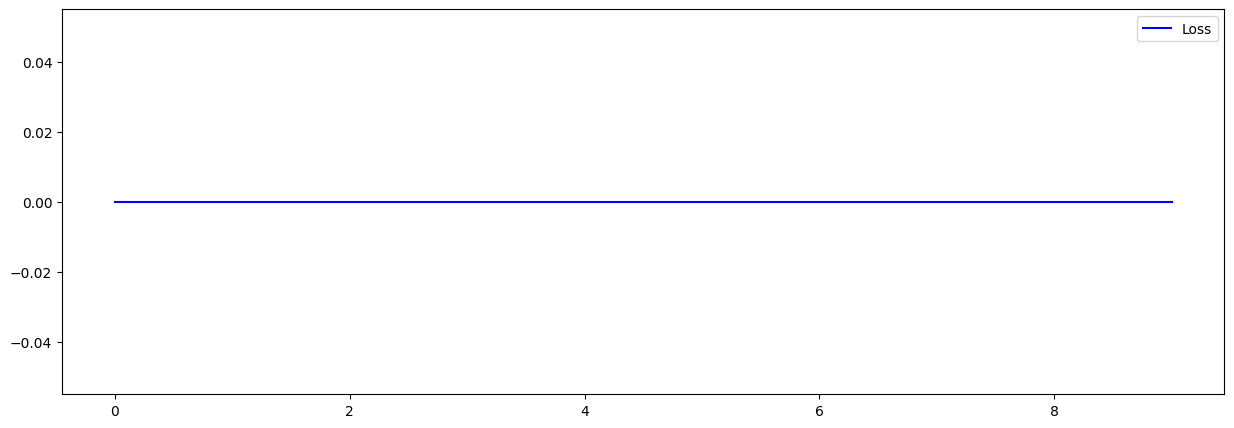

[0.49687498807907104, 0.49687495827674866, 0.49687498807907104, 0.49687495827674866, 0.49687498807907104, 0.49687492847442627, 0.49687498807907104, 0.49687498807907104, 0.49687498807907104, 0.49687501788139343] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]






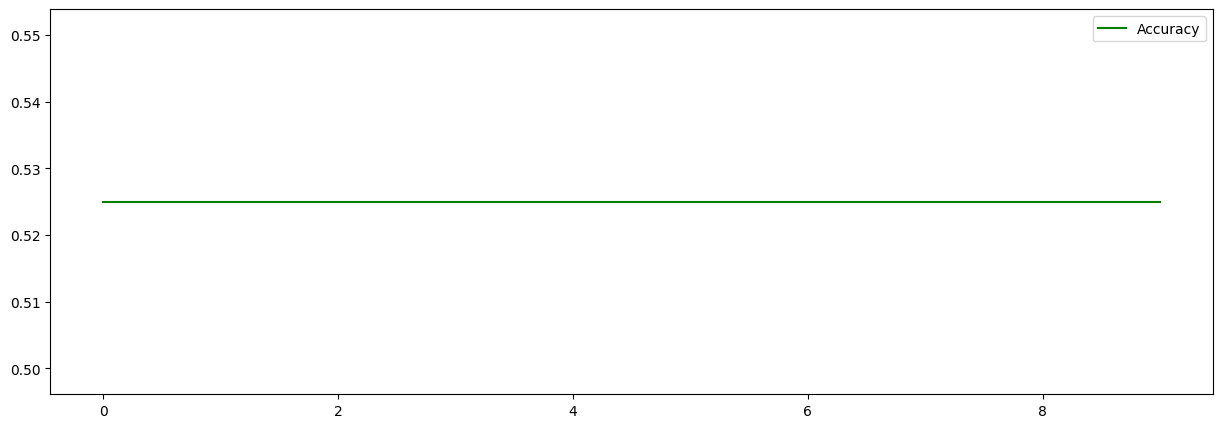

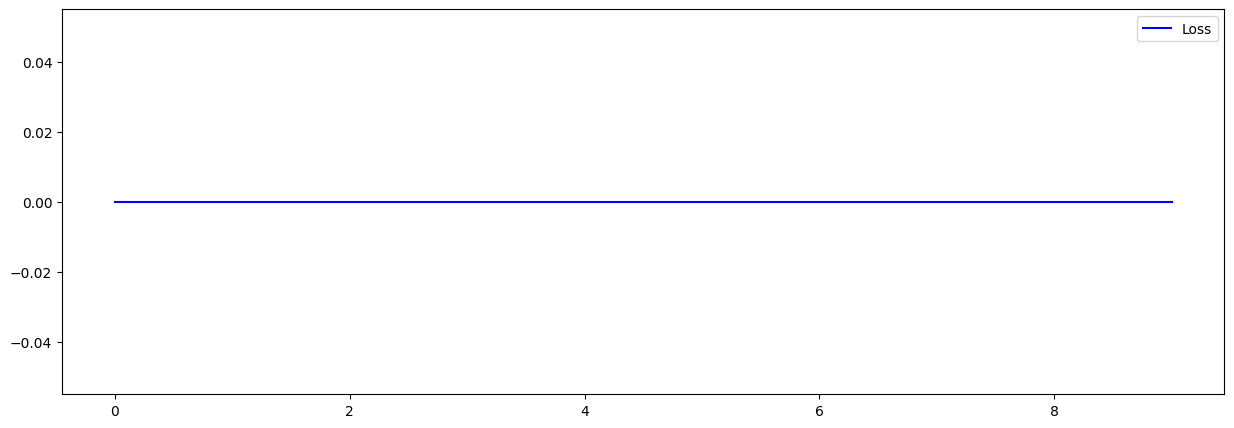

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
show_results(accuracy_values, loss_values)
print("\n" * 2 + "=" * 100 + "\n" * 2)
show_results(val_accuracy_values, val_loss_values)

# Train 1

Epoch : 1, train accuracy : 0.49687501788139343, train loss : 0.39440813660621643
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.28666555881500244


Epoch : 2, train accuracy : 0.49687492847442627, train loss : 0.23229382932186127
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.19799292087554932


Epoch : 3, train accuracy : 0.49687495827674866, train loss : 0.21269181370735168
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.16972270607948303


Epoch : 4, train accuracy : 0.49687495827674866, train loss : 0.19055472314357758
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.1346859633922577


Epoch : 5, train accuracy : 0.49687495827674866, train loss : 0.17337414622306824
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.12075893580913544


Epoch : 6, train accuracy : 0.49687495827674866, train loss : 0.16463863849639893
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.10973730683326721


Epoch : 7, train accuracy : 0.49687

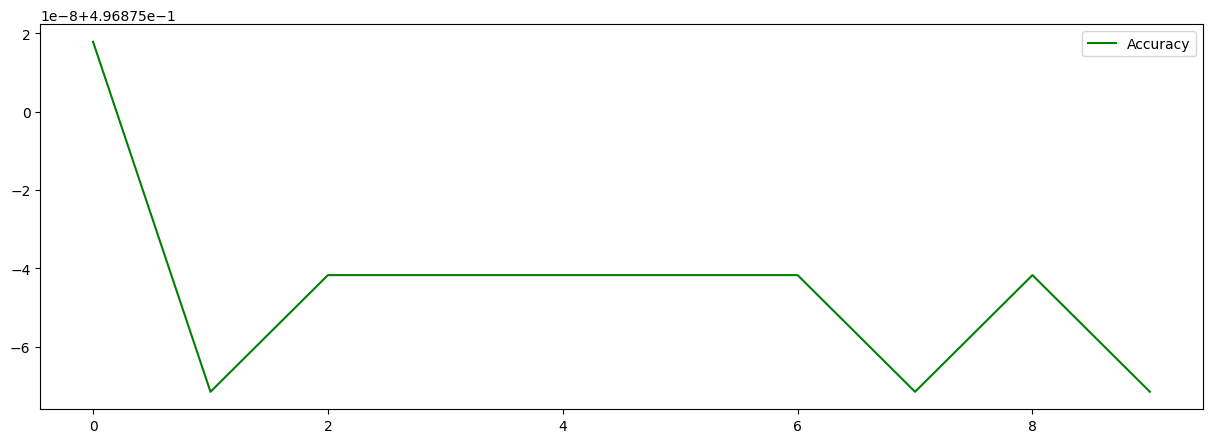

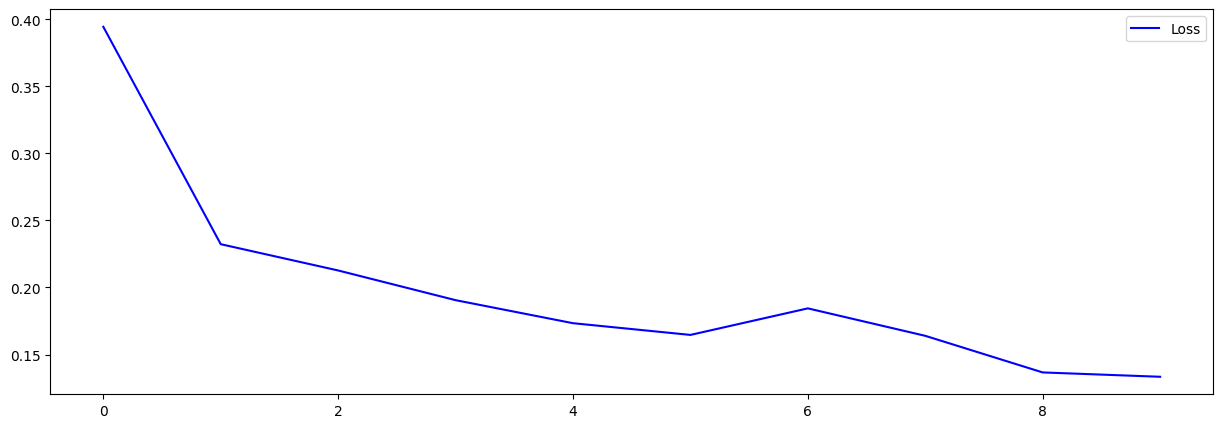

[0.49687501788139343, 0.49687492847442627, 0.49687495827674866, 0.49687495827674866, 0.49687495827674866, 0.49687495827674866, 0.49687495827674866, 0.49687492847442627, 0.49687495827674866, 0.49687492847442627] 
 [0.39440813660621643, 0.23229382932186127, 0.21269181370735168, 0.19055472314357758, 0.17337414622306824, 0.16463863849639893, 0.18443843722343445, 0.16396085917949677, 0.13666489720344543, 0.13342419266700745]


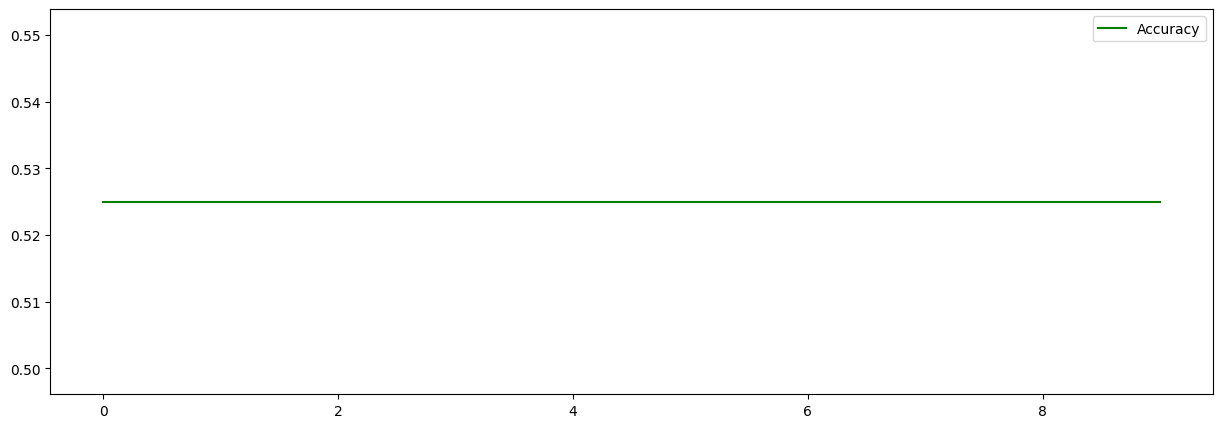

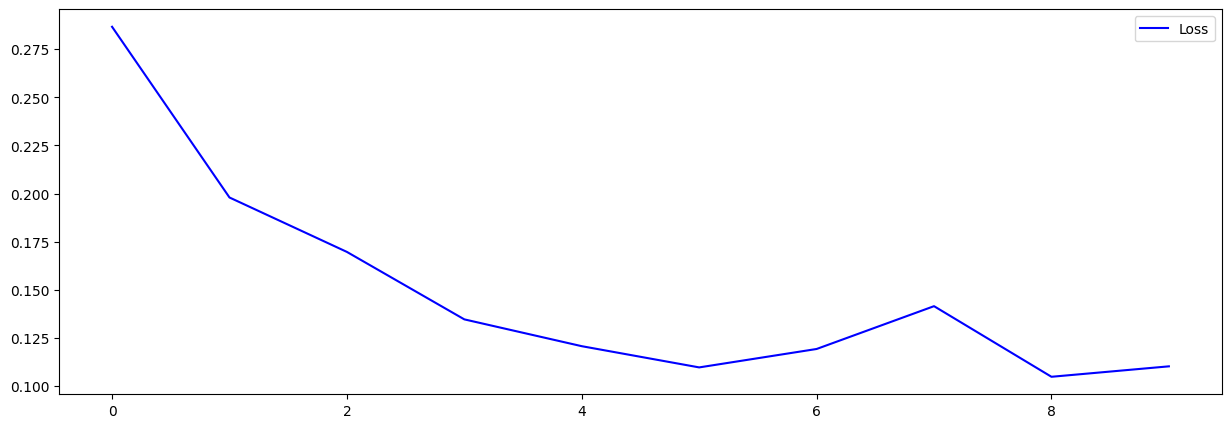

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.28666555881500244, 0.19799292087554932, 0.16972270607948303, 0.1346859633922577, 0.12075893580913544, 0.10973730683326721, 0.11930343508720398, 0.1415429562330246, 0.10486822575330734, 0.11028984189033508]


In [14]:
lear = 0.001
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train 2

Epoch : 1, train accuracy : 0.49687498807907104, train loss : 0.1477997601032257
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.21956346929073334


Epoch : 2, train accuracy : 0.49687498807907104, train loss : 0.2091626226902008
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.15081225335597992


Epoch : 3, train accuracy : 0.49687498807907104, train loss : 0.15412059426307678
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.0995987132191658


Epoch : 4, train accuracy : 0.49687498807907104, train loss : 0.1220644861459732
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.12112751603126526


Epoch : 5, train accuracy : 0.49687498807907104, train loss : 0.10833539068698883
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.09996379911899567


Epoch : 6, train accuracy : 0.49687501788139343, train loss : 0.12562313675880432
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.09137360751628876


Epoch : 7, train accuracy : 0.49687498

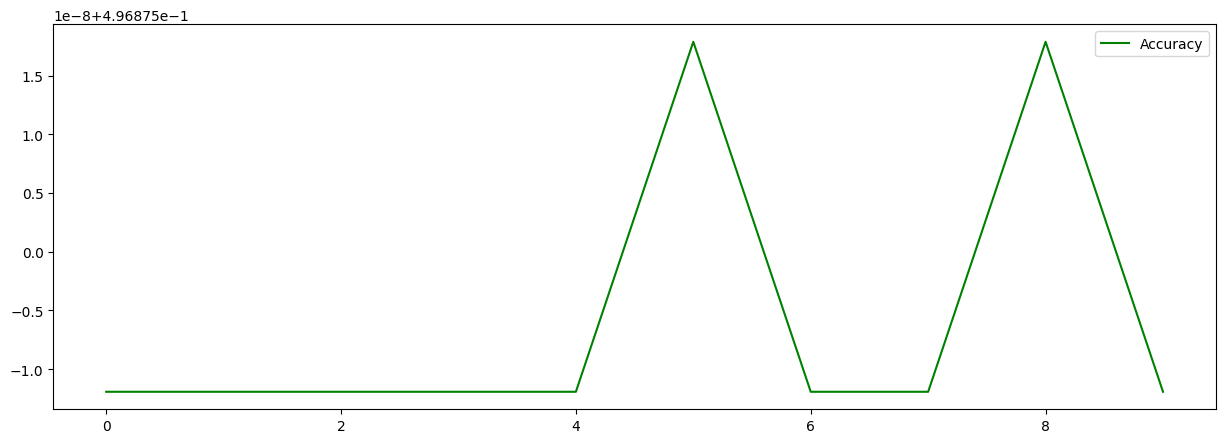

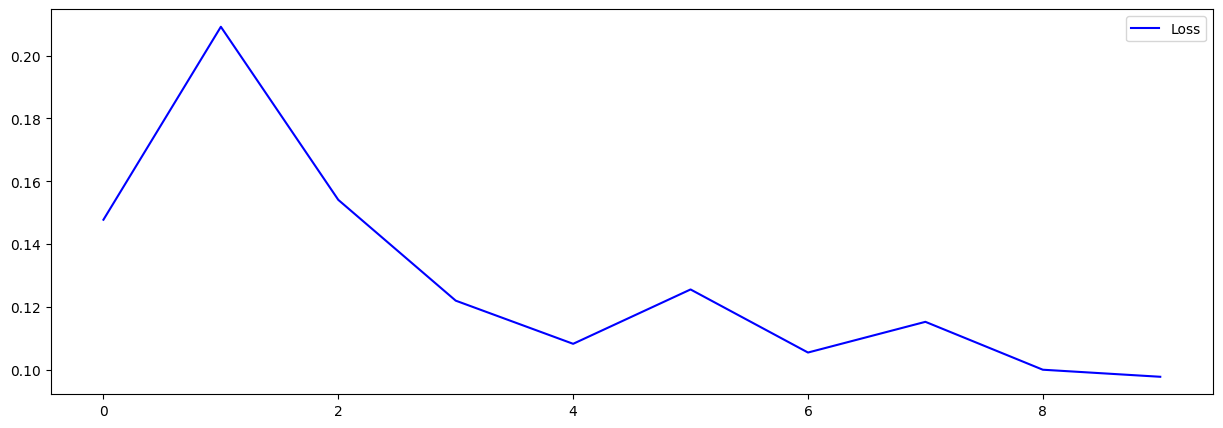

[0.49687498807907104, 0.49687498807907104, 0.49687498807907104, 0.49687498807907104, 0.49687498807907104, 0.49687501788139343, 0.49687498807907104, 0.49687498807907104, 0.49687501788139343, 0.49687498807907104] 
 [0.1477997601032257, 0.2091626226902008, 0.15412059426307678, 0.1220644861459732, 0.10833539068698883, 0.12562313675880432, 0.10556190460920334, 0.11532870680093765, 0.1000976413488388, 0.09785251319408417]


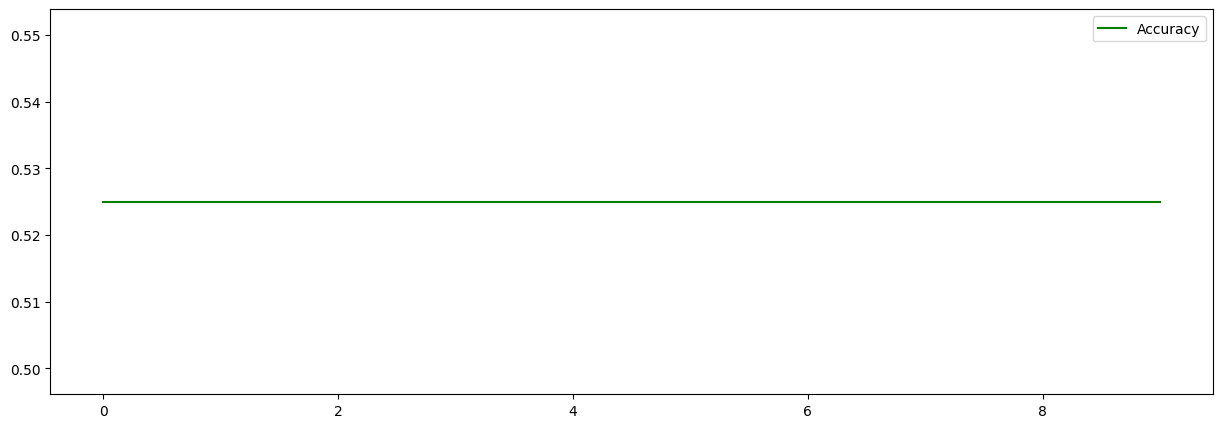

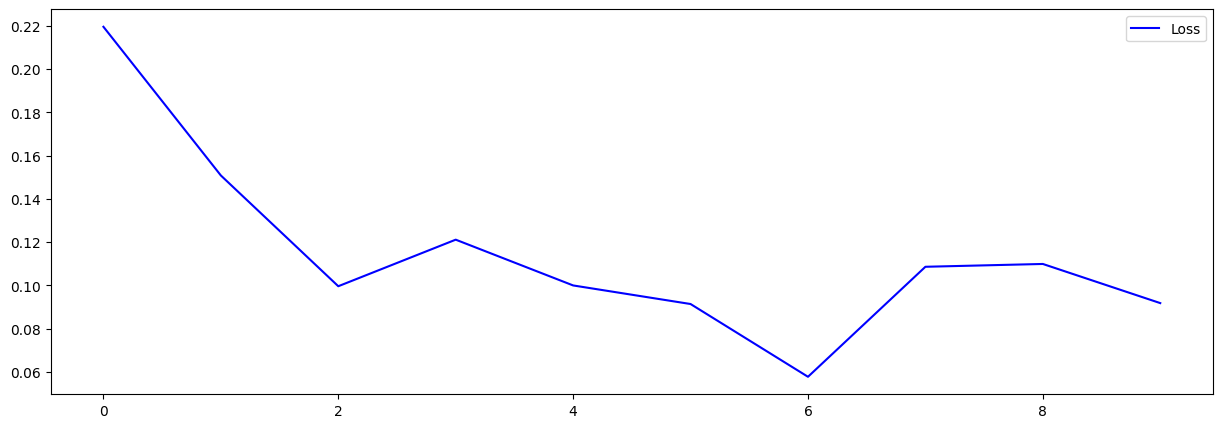

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.21956346929073334, 0.15081225335597992, 0.0995987132191658, 0.12112751603126526, 0.09996379911899567, 0.09137360751628876, 0.05773092806339264, 0.10859431326389313, 0.10989417880773544, 0.09179851412773132]


In [15]:
lear = 0.001
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train 3

Epoch : 1, train accuracy : 0.49687492847442627, train loss : 0.1208132728934288
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.10464909672737122


Epoch : 2, train accuracy : 0.49687495827674866, train loss : 0.1125708594918251
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.15603771805763245


Epoch : 3, train accuracy : 0.49687492847442627, train loss : 0.11930394917726517
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.09091963618993759


Epoch : 4, train accuracy : 0.49687498807907104, train loss : 0.11319568753242493
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.09654829651117325


Epoch : 5, train accuracy : 0.49687498807907104, train loss : 0.08883845806121826
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.057345226407051086


Epoch : 6, train accuracy : 0.49687492847442627, train loss : 0.08908512443304062
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.06376305967569351


Epoch : 7, train accuracy : 0.49687

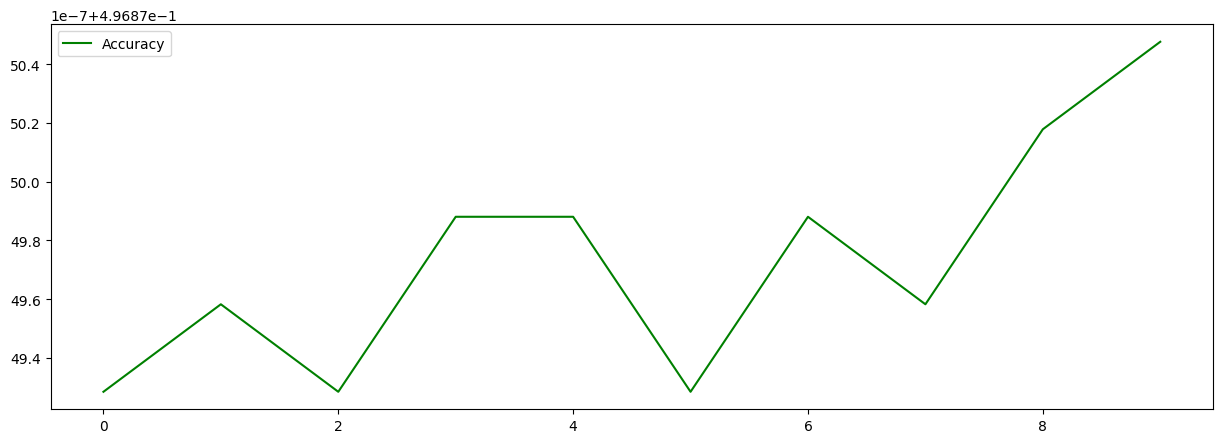

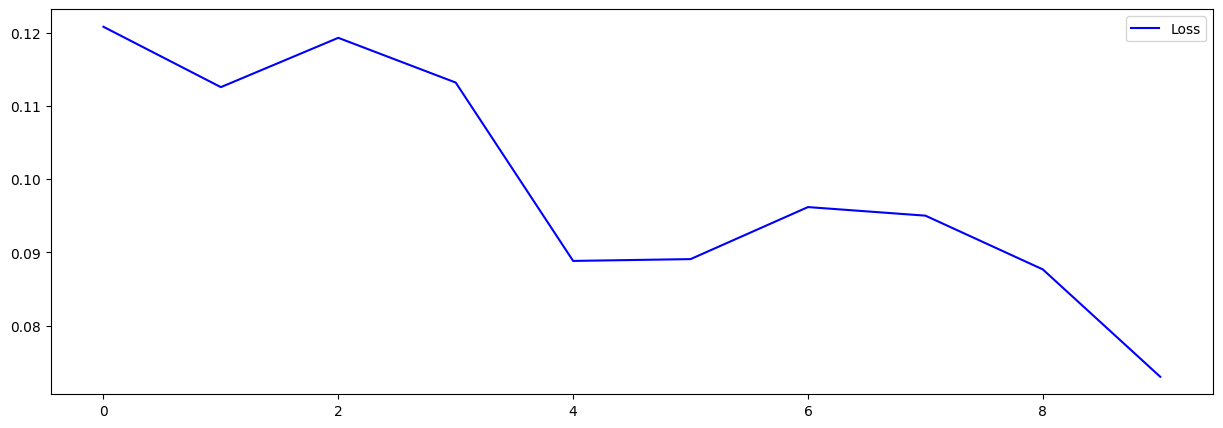

[0.49687492847442627, 0.49687495827674866, 0.49687492847442627, 0.49687498807907104, 0.49687498807907104, 0.49687492847442627, 0.49687498807907104, 0.49687495827674866, 0.49687501788139343, 0.4968750476837158] 
 [0.1208132728934288, 0.1125708594918251, 0.11930394917726517, 0.11319568753242493, 0.08883845806121826, 0.08908512443304062, 0.0961913987994194, 0.09502074122428894, 0.08767782896757126, 0.07301701605319977]


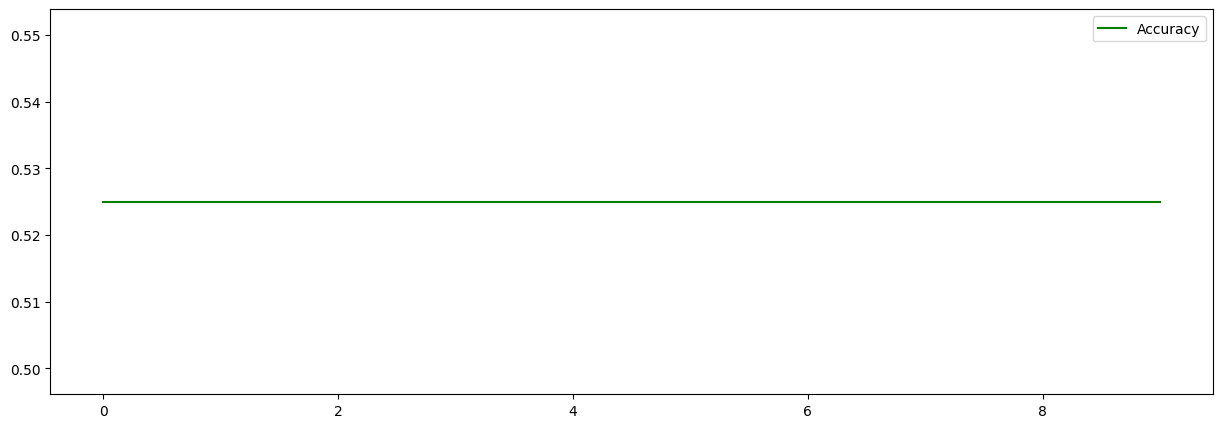

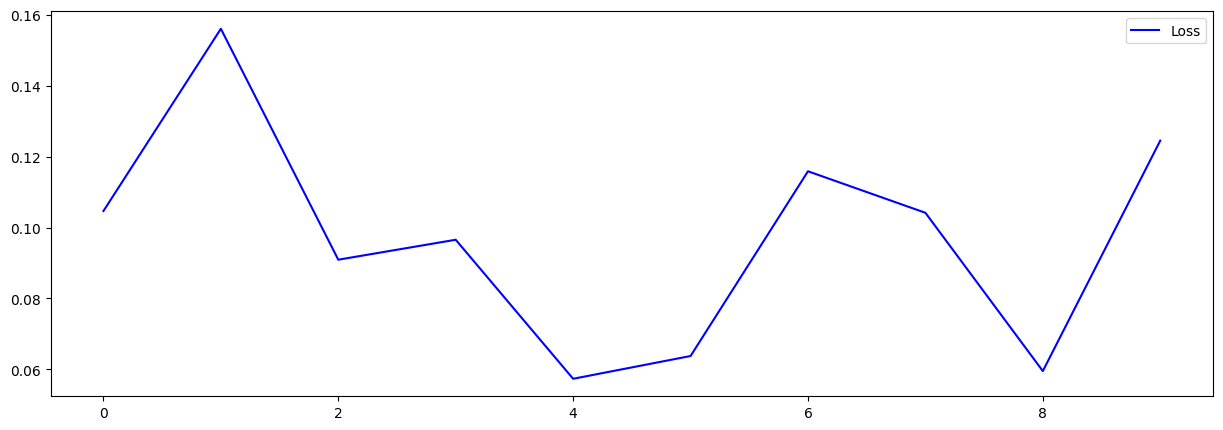

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.10464909672737122, 0.15603771805763245, 0.09091963618993759, 0.09654829651117325, 0.057345226407051086, 0.06376305967569351, 0.11585363745689392, 0.1041497141122818, 0.05951836705207825, 0.12450313568115234]


In [16]:

lear = 0.0005
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train 4

Epoch : 1, train accuracy : 0.49687498807907104, train loss : 0.11687277257442474
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.060958217829465866


Epoch : 2, train accuracy : 0.49687498807907104, train loss : 0.08445518463850021
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.10873948037624359


Epoch : 3, train accuracy : 0.49687498807907104, train loss : 0.08358308672904968
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.07622383534908295


Epoch : 4, train accuracy : 0.49687501788139343, train loss : 0.07793224602937698
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.05173404514789581


Epoch : 5, train accuracy : 0.49687492847442627, train loss : 0.07634153217077255
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.07079660892486572


Epoch : 6, train accuracy : 0.49687495827674866, train loss : 0.0786769762635231
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.059138428419828415


Epoch : 7, train accuracy : 0.496

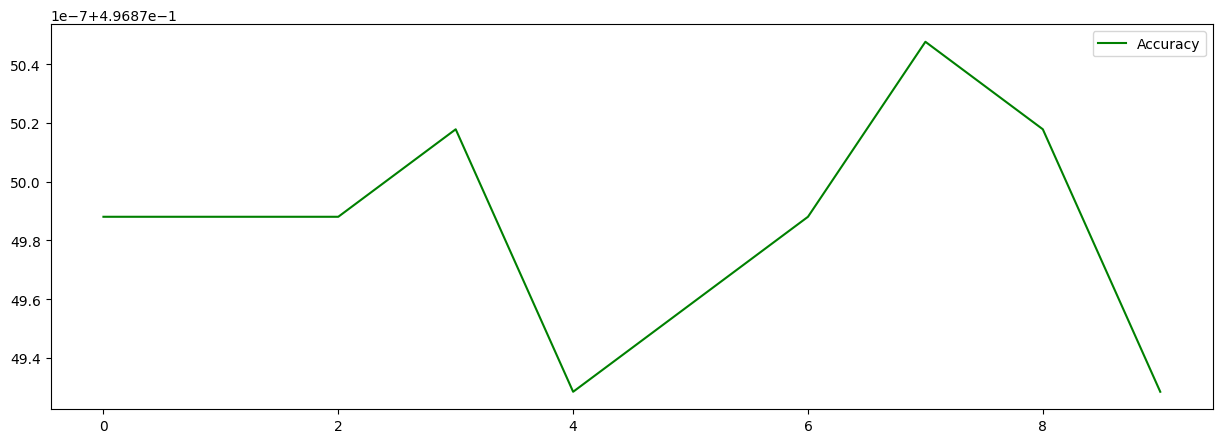

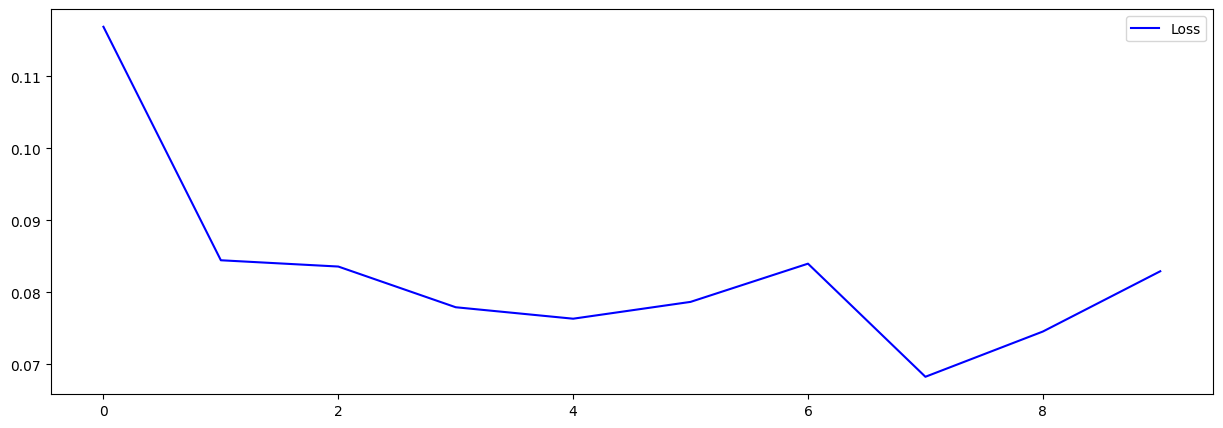

[0.49687498807907104, 0.49687498807907104, 0.49687498807907104, 0.49687501788139343, 0.49687492847442627, 0.49687495827674866, 0.49687498807907104, 0.4968750476837158, 0.49687501788139343, 0.49687492847442627] 
 [0.11687277257442474, 0.08445518463850021, 0.08358308672904968, 0.07793224602937698, 0.07634153217077255, 0.0786769762635231, 0.08398237824440002, 0.06827838718891144, 0.07455828040838242, 0.08292889595031738]


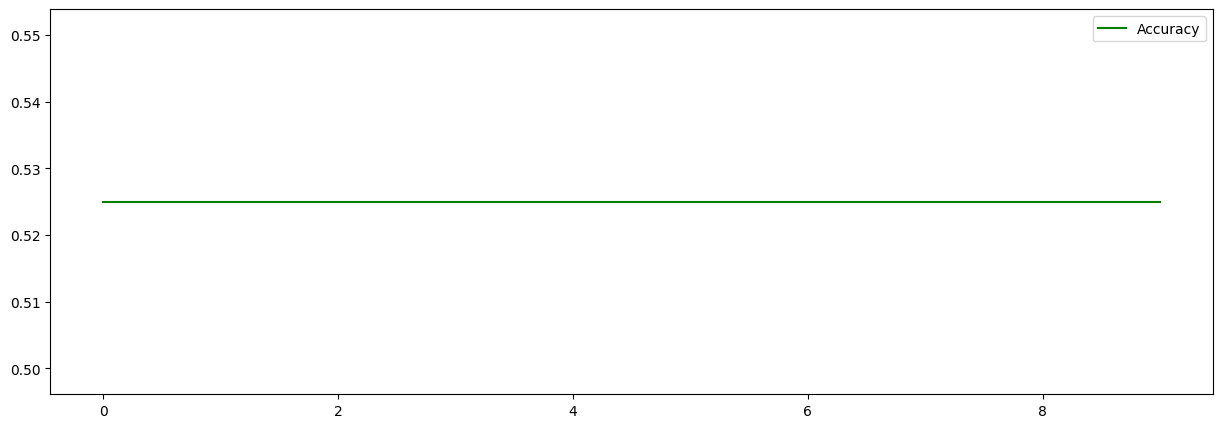

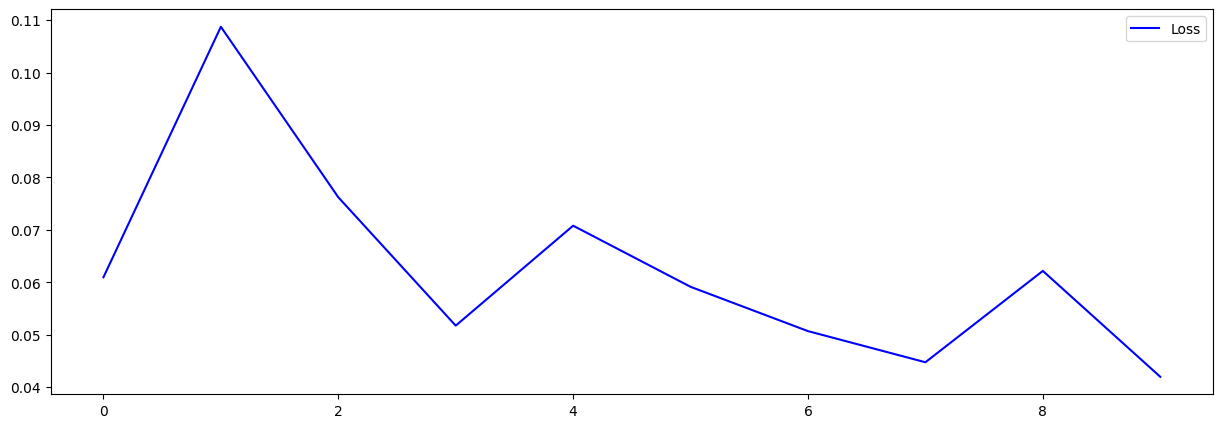

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.060958217829465866, 0.10873948037624359, 0.07622383534908295, 0.05173404514789581, 0.07079660892486572, 0.059138428419828415, 0.05068761855363846, 0.04474841058254242, 0.06217165291309357, 0.04197841137647629]


In [17]:
lear = 0.0005
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train 5

Epoch : 1, train accuracy : 0.49687498807907104, train loss : 0.08382759243249893
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.0774434506893158


Epoch : 2, train accuracy : 0.49687498807907104, train loss : 0.09568304568529129
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.07821489870548248


Epoch : 3, train accuracy : 0.49687498807907104, train loss : 0.09356167912483215
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.08131430298089981


Epoch : 4, train accuracy : 0.49687501788139343, train loss : 0.06756878644227982
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.056207701563835144


Epoch : 5, train accuracy : 0.49687498807907104, train loss : 0.05925026535987854
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.04611261934041977


Epoch : 6, train accuracy : 0.49687498807907104, train loss : 0.06735808402299881
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.06085265800356865


Epoch : 7, train accuracy : 0.4968

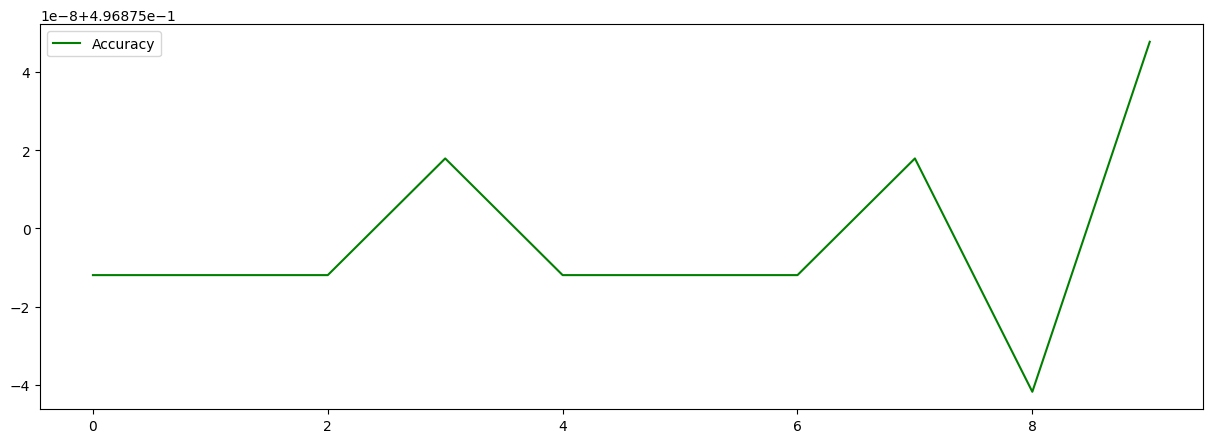

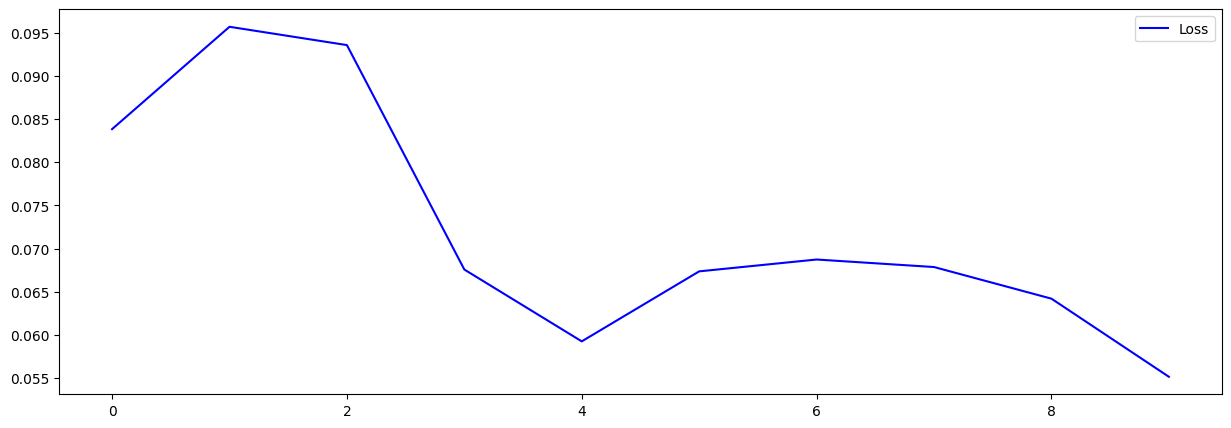

[0.49687498807907104, 0.49687498807907104, 0.49687498807907104, 0.49687501788139343, 0.49687498807907104, 0.49687498807907104, 0.49687498807907104, 0.49687501788139343, 0.49687495827674866, 0.4968750476837158] 
 [0.08382759243249893, 0.09568304568529129, 0.09356167912483215, 0.06756878644227982, 0.05925026535987854, 0.06735808402299881, 0.06872900575399399, 0.0678575336933136, 0.06419476866722107, 0.05514887347817421]


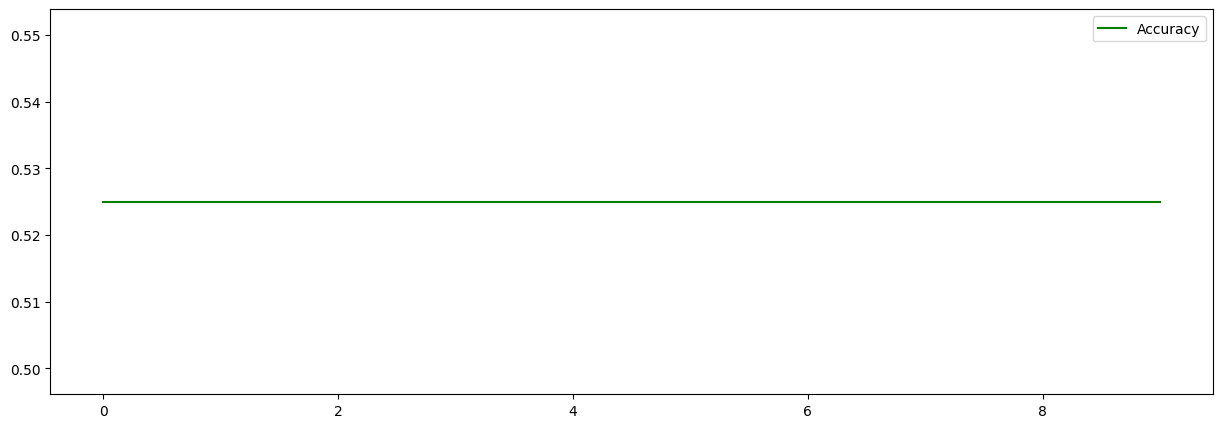

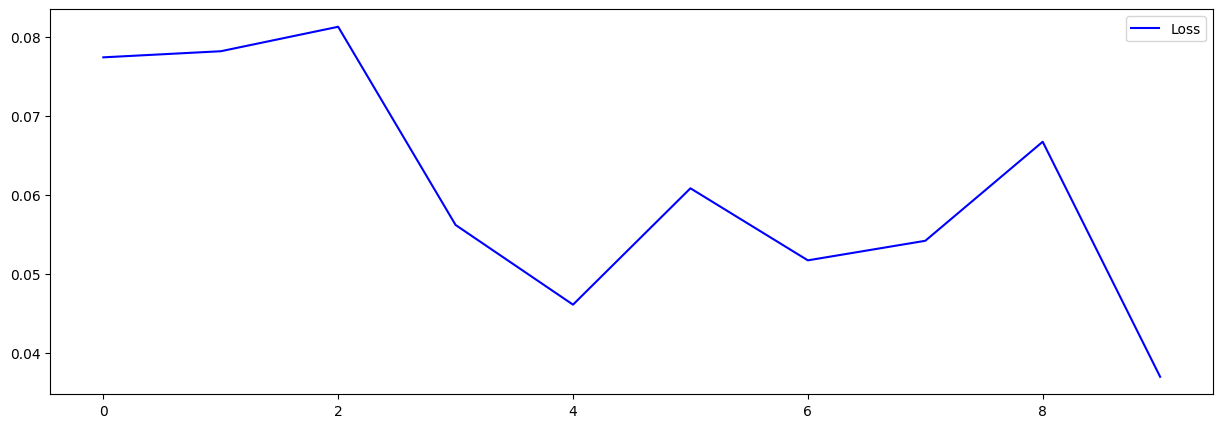

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.0774434506893158, 0.07821489870548248, 0.08131430298089981, 0.056207701563835144, 0.04611261934041977, 0.06085265800356865, 0.05172521248459816, 0.054202016443014145, 0.06674903631210327, 0.03697526827454567]


In [18]:
lear = 0.0005
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train 6

Epoch : 1, train accuracy : 0.49687501788139343, train loss : 0.2575138211250305
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.17747405171394348


Epoch : 2, train accuracy : 0.49687498807907104, train loss : 0.3294600248336792
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.15655171871185303


Epoch : 3, train accuracy : 0.49687495827674866, train loss : 0.1953287124633789
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.14420831203460693


Epoch : 4, train accuracy : 0.49687495827674866, train loss : 0.19118210673332214
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.12039704620838165


Epoch : 5, train accuracy : 0.49687495827674866, train loss : 0.16047243773937225
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.11202879250049591


Epoch : 6, train accuracy : 0.4968748986721039, train loss : 0.14401721954345703
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.21022531390190125


Epoch : 7, train accuracy : 0.49687501

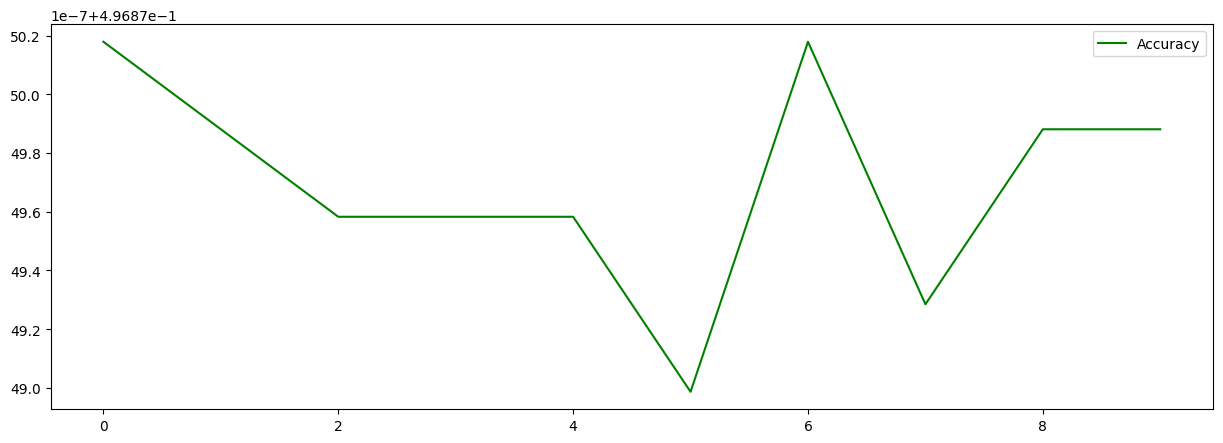

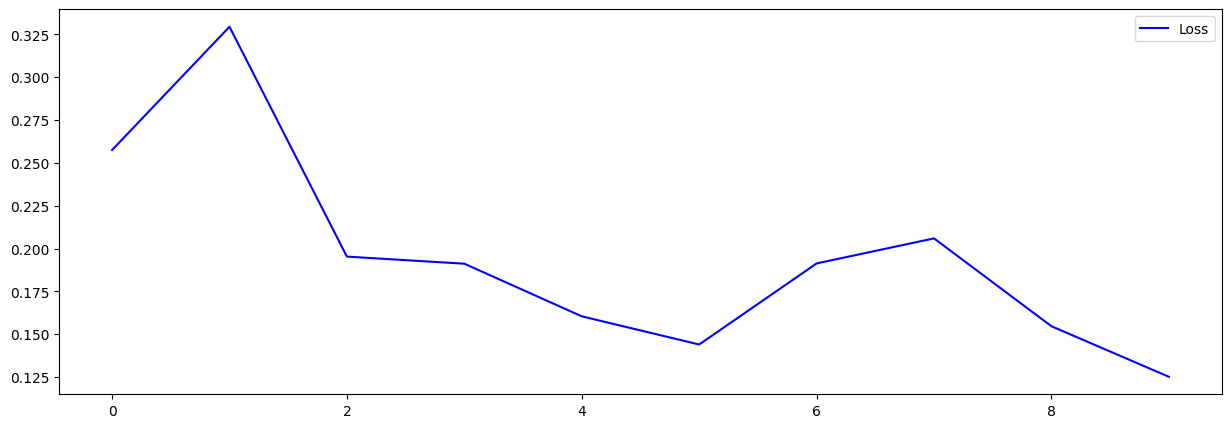

[0.49687501788139343, 0.49687498807907104, 0.49687495827674866, 0.49687495827674866, 0.49687495827674866, 0.4968748986721039, 0.49687501788139343, 0.49687492847442627, 0.49687498807907104, 0.49687498807907104] 
 [0.2575138211250305, 0.3294600248336792, 0.1953287124633789, 0.19118210673332214, 0.16047243773937225, 0.14401721954345703, 0.1913333237171173, 0.20595797896385193, 0.1546781212091446, 0.12518776953220367]


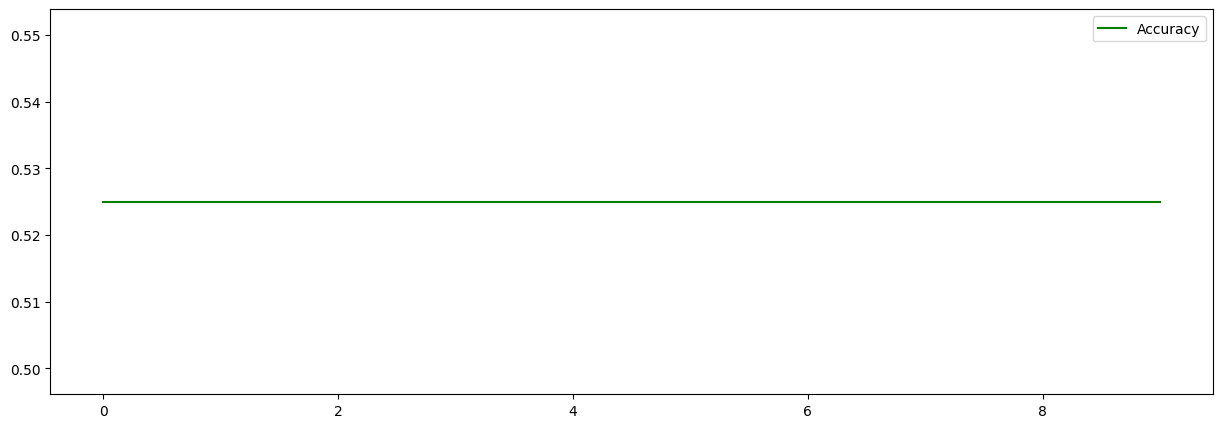

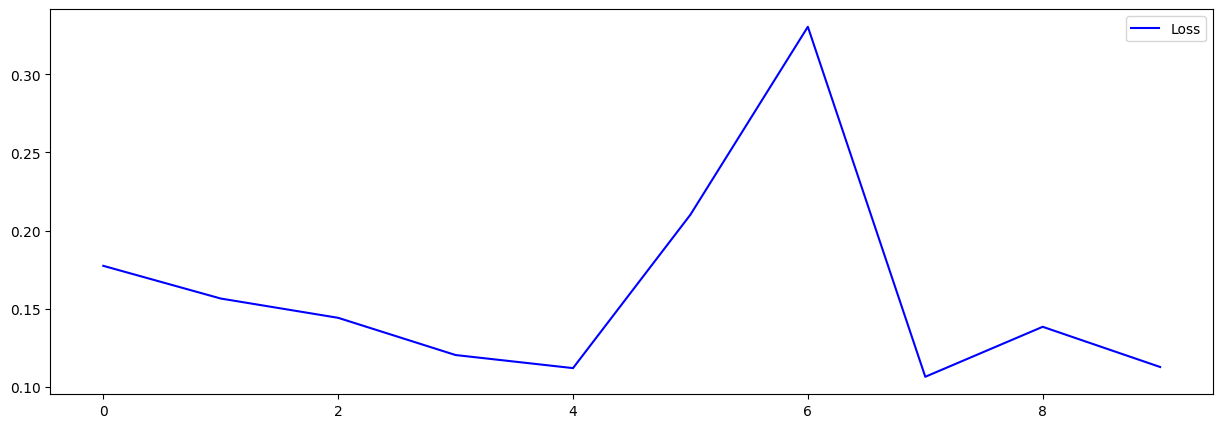

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.17747405171394348, 0.15655171871185303, 0.14420831203460693, 0.12039704620838165, 0.11202879250049591, 0.21022531390190125, 0.33043599128723145, 0.10648848861455917, 0.1384664922952652, 0.11274879425764084]


In [19]:
lear = 0.005
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train 7

Epoch : 1, train accuracy : 0.49687498807907104, train loss : 0.1738053560256958
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.19544139504432678


Epoch : 2, train accuracy : 0.49687501788139343, train loss : 0.1385694295167923
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.08446087688207626


Epoch : 3, train accuracy : 0.49687495827674866, train loss : 0.12177631258964539
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.0820273756980896


Epoch : 4, train accuracy : 0.49687498807907104, train loss : 0.13131320476531982
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.08513139933347702


Epoch : 5, train accuracy : 0.49687498807907104, train loss : 0.11429761350154877
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.13236692547798157


Epoch : 6, train accuracy : 0.49687495827674866, train loss : 0.11259457468986511
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.1120525673031807


Epoch : 7, train accuracy : 0.49687498

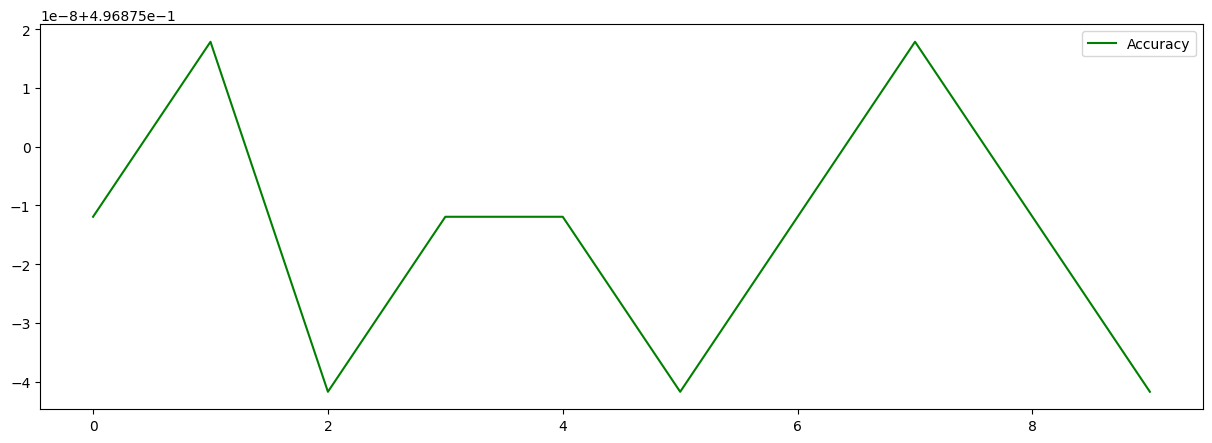

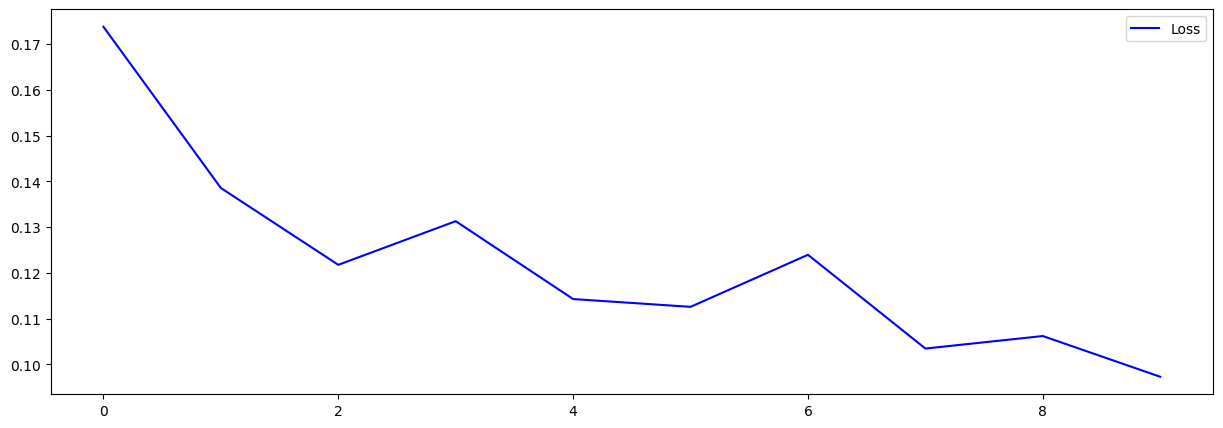

[0.49687498807907104, 0.49687501788139343, 0.49687495827674866, 0.49687498807907104, 0.49687498807907104, 0.49687495827674866, 0.49687498807907104, 0.49687501788139343, 0.49687498807907104, 0.49687495827674866] 
 [0.1738053560256958, 0.1385694295167923, 0.12177631258964539, 0.13131320476531982, 0.11429761350154877, 0.11259457468986511, 0.1239703968167305, 0.10347694903612137, 0.1062144935131073, 0.09730862826108932]


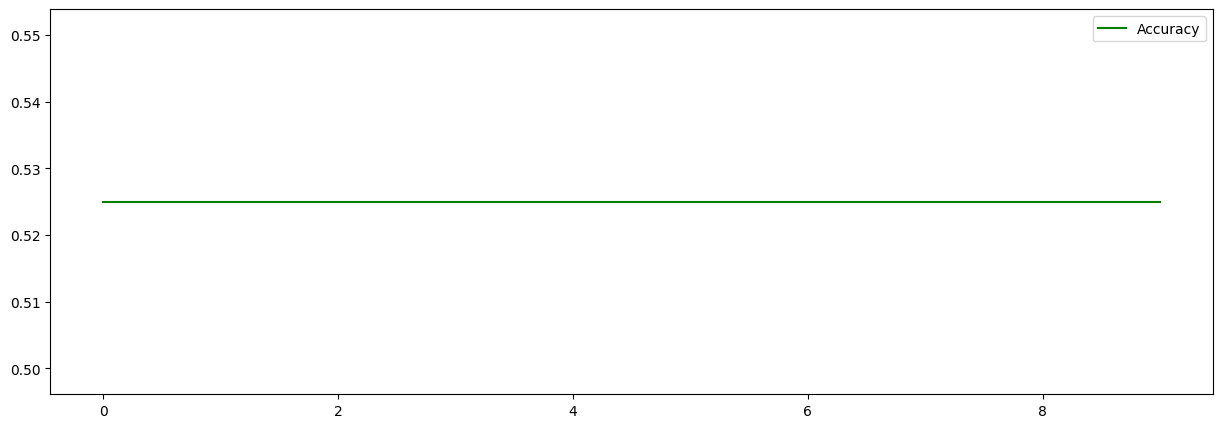

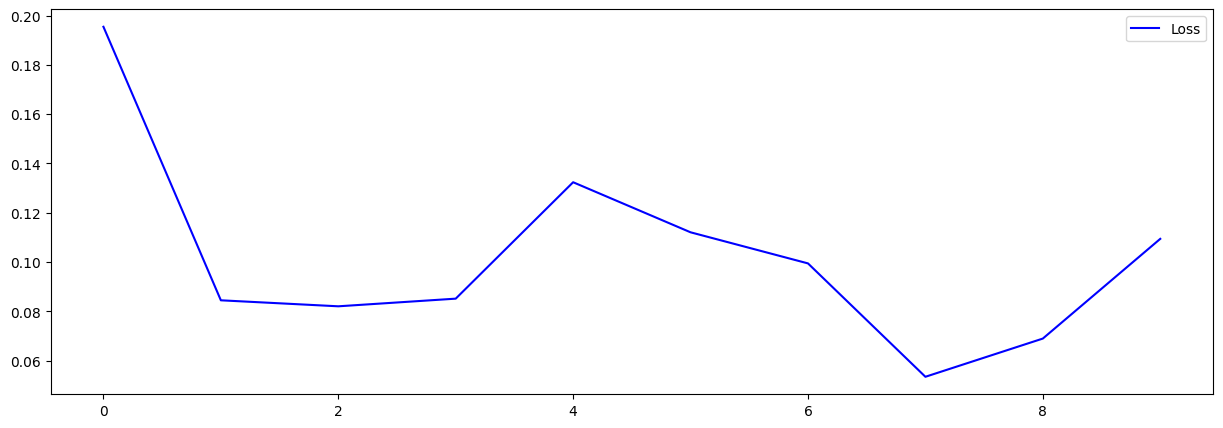

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.19544139504432678, 0.08446087688207626, 0.0820273756980896, 0.08513139933347702, 0.13236692547798157, 0.1120525673031807, 0.09943458437919617, 0.05343332514166832, 0.06893853098154068, 0.10939324647188187]


In [20]:
lear = 0.005
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Train 8

Epoch : 1, train accuracy : 0.4968750476837158, train loss : 0.12154509127140045
Epoch : 1, val_accuracy : 0.5249999761581421, val_loss : 0.11042884737253189


Epoch : 2, train accuracy : 0.49687501788139343, train loss : 0.1325543075799942
Epoch : 2, val_accuracy : 0.5249999761581421, val_loss : 0.06564733386039734


Epoch : 3, train accuracy : 0.49687498807907104, train loss : 0.0964025929570198
Epoch : 3, val_accuracy : 0.5249999761581421, val_loss : 0.08187595009803772


Epoch : 4, train accuracy : 0.4968750476837158, train loss : 0.08625196665525436
Epoch : 4, val_accuracy : 0.5249999761581421, val_loss : 0.049641117453575134


Epoch : 5, train accuracy : 0.49687498807907104, train loss : 0.087410107254982
Epoch : 5, val_accuracy : 0.5249999761581421, val_loss : 0.0790005698800087


Epoch : 6, train accuracy : 0.49687501788139343, train loss : 0.08728854358196259
Epoch : 6, val_accuracy : 0.5249999761581421, val_loss : 0.09023042023181915


Epoch : 7, train accuracy : 0.4968749880

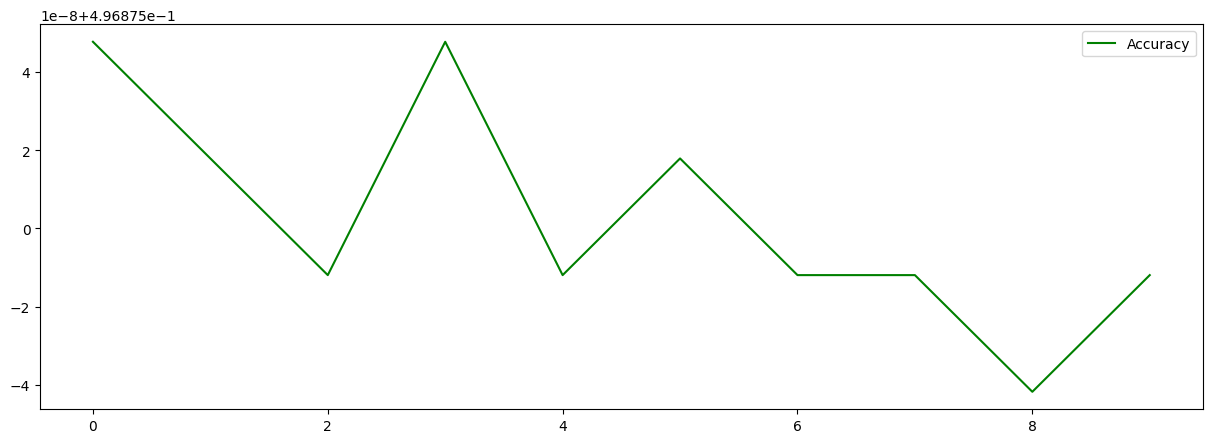

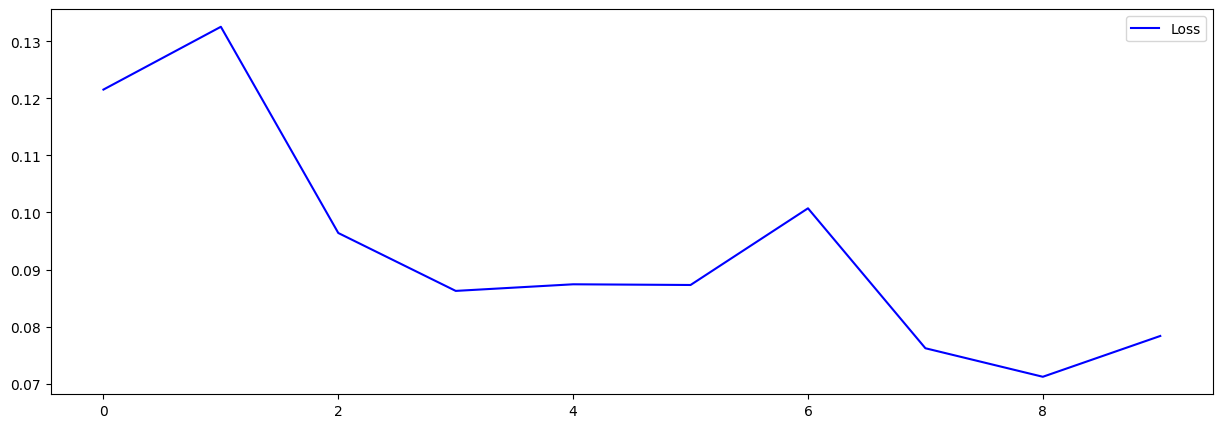

[0.4968750476837158, 0.49687501788139343, 0.49687498807907104, 0.4968750476837158, 0.49687498807907104, 0.49687501788139343, 0.49687498807907104, 0.49687498807907104, 0.49687495827674866, 0.49687498807907104] 
 [0.12154509127140045, 0.1325543075799942, 0.0964025929570198, 0.08625196665525436, 0.087410107254982, 0.08728854358196259, 0.10073080658912659, 0.07619810849428177, 0.07119690626859665, 0.07834983617067337]


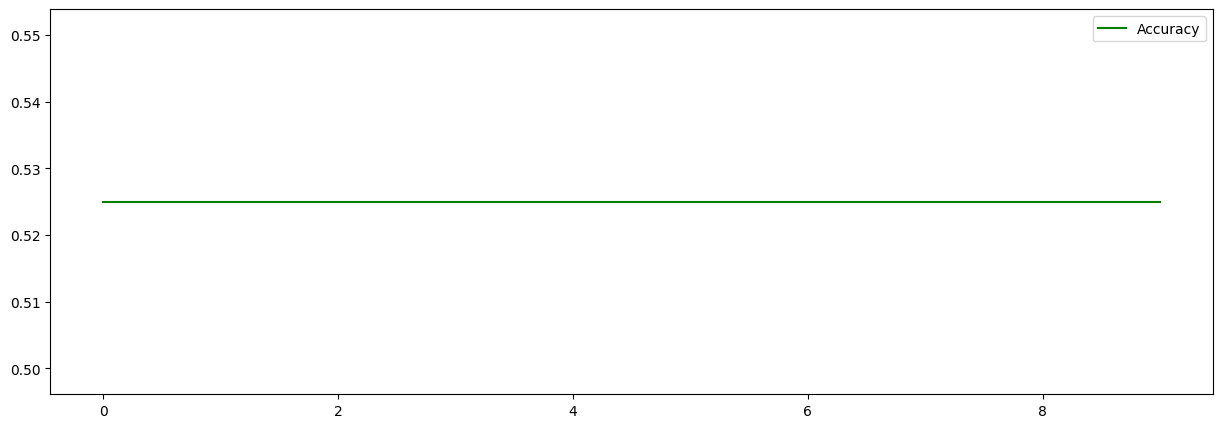

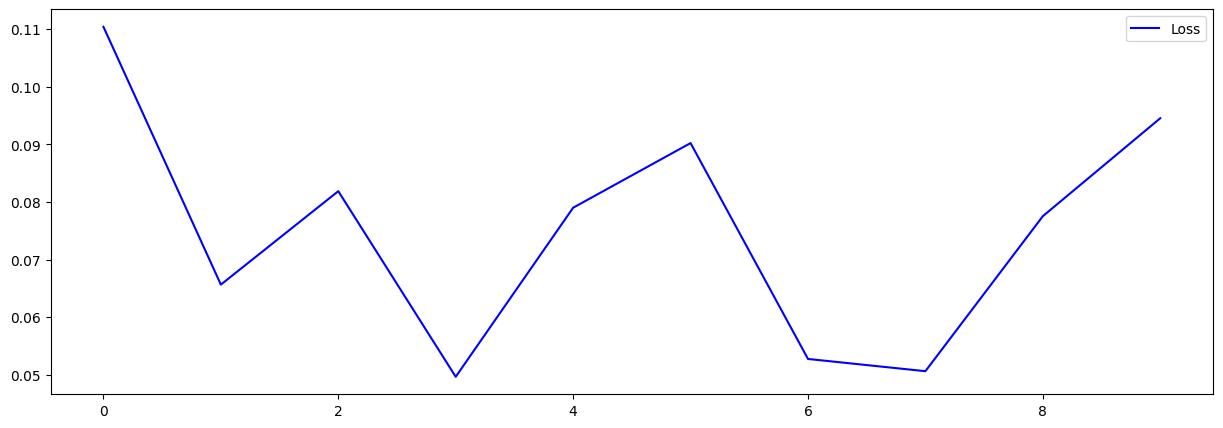

[0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421] 
 [0.11042884737253189, 0.06564733386039734, 0.08187595009803772, 0.049641117453575134, 0.0790005698800087, 0.09023042023181915, 0.052736327052116394, 0.0506114736199379, 0.07753352075815201, 0.09454423934221268]


In [21]:
lear = 0.005
batch_size = 200

train_loader = torch.utils.data.DataLoader(dataset = myds_train, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = myds_valid, batch_size=batch_size, shuffle=False)

optimizer = optim.Adam(params = model.parameters(), lr = lear)
criterion = nn.BCELoss()

accuracy_values = []
loss_values = []

val_accuracy_values = []
val_loss_values = []

train_loop(train_loader, val_loader)

show_results(accuracy_values, loss_values)

show_results(val_accuracy_values, val_loss_values)

# Пункт 9
Сохранение обученной модели

In [22]:
torch.save(model.state_dict(), "weight.pt")

# Пункт 10
Повторная инициализация модели и загрузка весов

In [23]:
newmodel = Cnn()
newmodel.load_state_dict(torch.load("weight.pt"))

<All keys matched successfully>

In [24]:
newmodel.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in loader_test:
    data = data.to(device)
    label = label.to(device)

    output = newmodel(data)
    loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).mean()
    test_accuracy += acc / len(loader_test)
    test_loss += float(loss.detach()) / len(loader_test)

# Результат выполнения

In [25]:
print(test_accuracy, test_loss)

0.875 0.0392202939838171


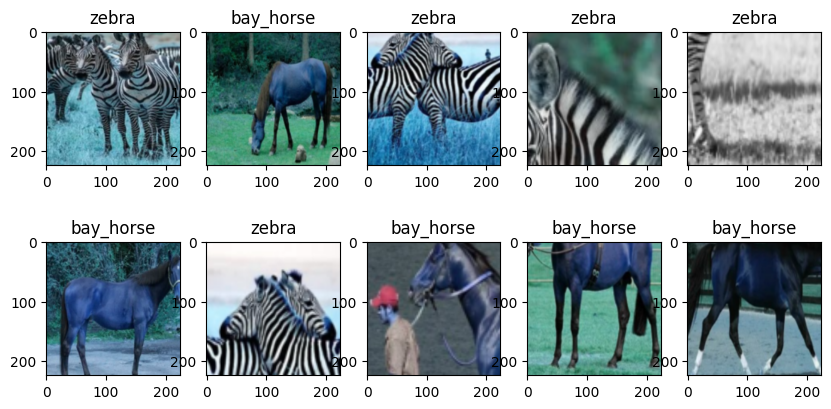

In [31]:
import random
plt.figure(figsize=(10, 5))

for j in range(10):
  index = random.randint(0, len(myds_test))
  plt.subplot(2, 5, j + 1)
  plt.title("zebra" if (1 if  model(myds_test[index][0].unsqueeze(dim=0))[0] >= 0.5 else 0) == 0 else "bay_horse")
  plt.imshow(myds_test[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])